In [1]:
import pandas as pd
import glob
import tensorflow as tf
from tensorflow.data import Dataset
from matplotlib import pyplot
from tensorflow.keras.callbacks import TensorBoard
import numpy as np

2021-10-20 19:18:25.956252: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2021-10-20 19:18:25.956294: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [2]:
path =r'../data/datasets_by_year/'
filenames = glob.glob(path + "/*.csv")

dfs = []
for filename in filenames:
    df = pd.read_csv(filename).drop(columns=["Unnamed: 0", "individual-local-identifier"])
    if df.shape > (40,):
        dfs.append(df[["location-long", "location-lat"]])

In [3]:
def split_data(df):

    n = len(df)
    train_df = df[0:int(n*0.7)]
    val_df = df[int(n*0.7):]
    #test_df = df[int(n*0.9):]

    num_features = df.shape[1]
    
    return train_df, val_df#,test_df

In [4]:
split_data_result = [split_data(df) for df in dfs]

In [5]:
df_23043 = pd.read_csv("../data/datasets_by_year/1999CA-Bmu-23043.csv")[["location-long", "location-lat"]]

In [6]:
train_df,val_df = split_data(df_23043)

In [7]:
def data_windowing(train_df,val_df):
    n_points = 20
    window_length = n_points+ 1 
    
    window_train = tf.keras.utils.timeseries_dataset_from_array(
    train_df, targets=None,sequence_length = window_length, sequence_stride=1, sampling_rate=1,
    batch_size=32, shuffle=False, seed=None, start_index=None, end_index=None)
    
    """
    window_test = tf.keras.utils.timeseries_dataset_from_array(
    test_df, targets=None,sequence_length = window_length, sequence_stride=1, sampling_rate=1,
    batch_size=32, shuffle=False, seed=None, start_index=None, end_index=None)
    """
        
    window_val = tf.keras.utils.timeseries_dataset_from_array(
    val_df, targets=None,sequence_length = window_length, sequence_stride=1, sampling_rate=1,
    batch_size=32, shuffle=False, seed=None, start_index=None, end_index=None)
    
    return window_train, window_val

In [8]:
def data_map(elem):
    n_points = 20
    window_length = n_points+ 1 
    X,y = elem[:,:-1,:],elem[:,-1:,0:2]
    X.set_shape([None, n_points, None])
    y.set_shape([None, window_length - n_points, None])
    
    return (X,y)


In [9]:
lstm_model = tf.keras.models.Sequential([
    tf.keras.layers.LSTM(32, return_sequences=False),
    tf.keras.layers.Dense(units=10),
    tf.keras.layers.Dropout(rate=0.1),
    tf.keras.layers.Dense(units=10),
    tf.keras.layers.Dense(units=10),
    tf.keras.layers.Dense(units=10),
    tf.keras.layers.Dense(units=2)
])

2021-10-20 19:18:28.000222: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2021-10-20 19:18:28.000270: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2021-10-20 19:18:28.000303: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (DESKTOP-R3AGIN3): /proc/driver/nvidia/version does not exist
2021-10-20 19:18:28.000505: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [10]:
lstm_model.compile(loss=tf.losses.MeanSquaredError(),optimizer=tf.optimizers.Adam(learning_rate=0.00005),metrics=[tf.metrics.MeanAbsoluteError()])

In [11]:
window_train,window_val = data_windowing(train_df,val_df)
train = window_train.map(data_map)
#test = window_test.map(data_map)
val = window_val.map(data_map)

early_stopping = tf.keras.callbacks.EarlyStopping(monitor='loss',
                                                patience=5,
                                                mode='min')

tensorboard_callback = TensorBoard(log_dir="./logs", histogram_freq=2)

history = lstm_model.fit(train, epochs=300,
                         validation_data=val,
                         callbacks=[early_stopping, tensorboard_callback])




2021-10-20 19:18:28.189827: I tensorflow/core/profiler/lib/profiler_session.cc:131] Profiler session initializing.
2021-10-20 19:18:28.189870: I tensorflow/core/profiler/lib/profiler_session.cc:146] Profiler session started.
2021-10-20 19:18:28.189914: I tensorflow/core/profiler/lib/profiler_session.cc:164] Profiler session tear down.
2021-10-20 19:18:28.209336: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/300
6/9 [===================>..........] - ETA: 0s - loss: 7859.7246 - mean_absolute_error: 77.6261

2021-10-20 19:18:29.735521: I tensorflow/core/profiler/lib/profiler_session.cc:131] Profiler session initializing.
2021-10-20 19:18:29.735566: I tensorflow/core/profiler/lib/profiler_session.cc:146] Profiler session started.
2021-10-20 19:18:29.754193: I tensorflow/core/profiler/lib/profiler_session.cc:66] Profiler session collecting data.
2021-10-20 19:18:29.760525: I tensorflow/core/profiler/lib/profiler_session.cc:164] Profiler session tear down.
2021-10-20 19:18:29.789022: I tensorflow/core/profiler/rpc/client/save_profile.cc:136] Creating directory: ./logs/train/plugins/profile/2021_10_20_19_18_29

2021-10-20 19:18:29.803839: I tensorflow/core/profiler/rpc/client/save_profile.cc:142] Dumped gzipped tool data for trace.json.gz to ./logs/train/plugins/profile/2021_10_20_19_18_29/DESKTOP-R3AGIN3.trace.json.gz
2021-10-20 19:18:29.819331: I tensorflow/core/profiler/rpc/client/save_profile.cc:136] Creating directory: ./logs/train/plugins/profile/2021_10_20_19_18_29

2021-10-20 19:18:29.

9/9 [==============================] - 2s 79ms/step - loss: 7951.2905 - mean_absolute_error: 78.1612 - val_loss: 7388.7905 - val_mean_absolute_error: 73.4809
Epoch 2/300
9/9 [==============================] - 0s 18ms/step - loss: 7951.2178 - mean_absolute_error: 78.1595 - val_loss: 7383.1899 - val_mean_absolute_error: 73.4554
Epoch 3/300
9/9 [==============================] - 0s 19ms/step - loss: 7939.4482 - mean_absolute_error: 78.1070 - val_loss: 7377.5791 - val_mean_absolute_error: 73.4299
Epoch 4/300
9/9 [==============================] - 0s 18ms/step - loss: 7931.3350 - mean_absolute_error: 78.0722 - val_loss: 7371.9941 - val_mean_absolute_error: 73.4045
Epoch 5/300
9/9 [==============================] - 0s 17ms/step - loss: 7928.8008 - mean_absolute_error: 78.0609 - val_loss: 7366.4058 - val_mean_absolute_error: 73.3790
Epoch 6/300
9/9 [==============================] - 0s 18ms/step - loss: 7917.9956 - mean_absolute_error: 78.0128 - val_loss: 7360.7681 - val_mean_absolute_error: 

9/9 [==============================] - 0s 17ms/step - loss: 7294.9834 - mean_absolute_error: 75.0782 - val_loss: 6800.7632 - val_mean_absolute_error: 70.5910
Epoch 50/300
9/9 [==============================] - 0s 16ms/step - loss: 7257.1421 - mean_absolute_error: 74.8891 - val_loss: 6769.3120 - val_mean_absolute_error: 70.4276
Epoch 51/300
9/9 [==============================] - 0s 16ms/step - loss: 7223.8364 - mean_absolute_error: 74.7252 - val_loss: 6736.4673 - val_mean_absolute_error: 70.2563
Epoch 52/300
9/9 [==============================] - 0s 16ms/step - loss: 7185.9844 - mean_absolute_error: 74.5358 - val_loss: 6702.1411 - val_mean_absolute_error: 70.0769
Epoch 53/300
9/9 [==============================] - 0s 16ms/step - loss: 7150.3301 - mean_absolute_error: 74.3549 - val_loss: 6666.3589 - val_mean_absolute_error: 69.8894
Epoch 54/300
9/9 [==============================] - 0s 16ms/step - loss: 7108.1040 - mean_absolute_error: 74.1394 - val_loss: 6629.1006 - val_mean_absolute_er

Epoch 97/300
9/9 [==============================] - 0s 15ms/step - loss: 1890.9973 - mean_absolute_error: 38.7117 - val_loss: 1789.4376 - val_mean_absolute_error: 35.4424
Epoch 98/300
9/9 [==============================] - 0s 16ms/step - loss: 1833.6722 - mean_absolute_error: 37.9771 - val_loss: 1692.4064 - val_mean_absolute_error: 34.4082
Epoch 99/300
9/9 [==============================] - 0s 16ms/step - loss: 1769.8535 - mean_absolute_error: 37.3617 - val_loss: 1594.0549 - val_mean_absolute_error: 33.3309
Epoch 100/300
9/9 [==============================] - 0s 16ms/step - loss: 1624.0366 - mean_absolute_error: 35.7314 - val_loss: 1496.0580 - val_mean_absolute_error: 32.2235
Epoch 101/300
9/9 [==============================] - 0s 16ms/step - loss: 1516.0292 - mean_absolute_error: 34.5730 - val_loss: 1402.4219 - val_mean_absolute_error: 31.1273
Epoch 102/300
9/9 [==============================] - 0s 17ms/step - loss: 1509.1223 - mean_absolute_error: 34.3552 - val_loss: 1316.1986 - val_

9/9 [==============================] - 0s 16ms/step - loss: 135.7704 - mean_absolute_error: 7.7629 - val_loss: 66.0321 - val_mean_absolute_error: 5.9544
Epoch 146/300
9/9 [==============================] - 0s 16ms/step - loss: 119.6418 - mean_absolute_error: 7.2096 - val_loss: 62.3072 - val_mean_absolute_error: 5.6921
Epoch 147/300
9/9 [==============================] - 0s 16ms/step - loss: 124.3193 - mean_absolute_error: 7.2971 - val_loss: 58.8952 - val_mean_absolute_error: 5.4357
Epoch 148/300
9/9 [==============================] - 0s 15ms/step - loss: 132.3061 - mean_absolute_error: 7.7860 - val_loss: 55.7410 - val_mean_absolute_error: 5.2209
Epoch 149/300
9/9 [==============================] - 0s 15ms/step - loss: 117.1562 - mean_absolute_error: 7.5523 - val_loss: 52.8570 - val_mean_absolute_error: 5.0709
Epoch 150/300
9/9 [==============================] - 0s 16ms/step - loss: 101.4055 - mean_absolute_error: 7.0511 - val_loss: 50.8347 - val_mean_absolute_error: 4.9883
Epoch 151/30

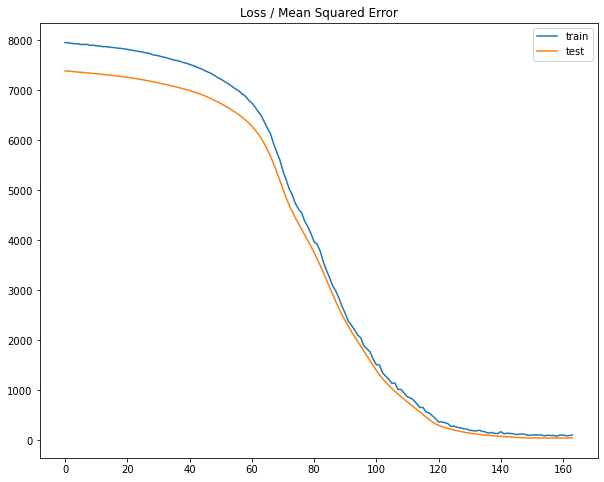

In [12]:
pyplot.figure(figsize=(10,8))
pyplot.title('Loss / Mean Squared Error')
pyplot.plot(history.history['loss'], label='train')
pyplot.plot(history.history['val_loss'], label='test')
pyplot.legend()
pyplot.show()

In [30]:
list(val.take(1).as_numpy_iterator())[0][1][0][0]

array([-122.878,   37.589])

In [33]:
np.array([list(val.take(1).as_numpy_iterator())[0][0][0]]).shape

(1, 20, 2)

In [23]:
lstm_model.layers[0].input_shape

(None, 20, 2)

In [40]:
np.array([val_df[:20]])

(1, 20, 2)

In [60]:
val_df[:21]

,location-long,location-lat
290,-123.140,37.667
291,-122.513,37.741
292,-123.055,37.716
293,-123.105,37.725
294,-123.265,37.712
295,-123.220,37.522
296,-123.032,37.607
297,-123.182,37.659
298,-122.890,37.546
299,-122.928,37.625


In [50]:
y_pred = lstm_model.predict(np.array([val_df[:20]]))[0]

In [61]:
y_pred 

array([-119.34082 ,   34.686966], dtype=float32)

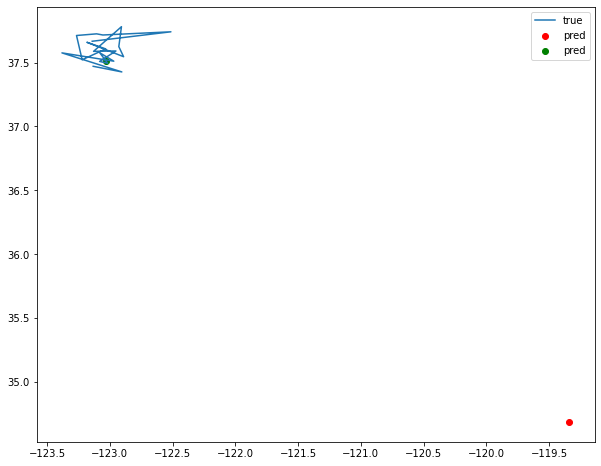

In [59]:
pyplot.figure(figsize=(10,8))
pyplot.plot(val_df[:20]["location-long"], val_df[:20]["location-lat"], label='true')
pyplot.scatter(y_pred[0], y_pred[1],  c="red", label='pred')
pyplot.scatter(val_df.iloc[21][0], val_df.iloc[21][1],  c="green", label='pred')
pyplot.legend()
pyplot.show()

In [45]:
val_df.iloc[21]

location-long   -123.031
location-lat      37.511
Name: 311, dtype: float64

In [35]:
lstm_model.predict(np.array([list(val.take(1).as_numpy_iterator())[0][0][0]]))

array([[-119.34082 ,   34.686966]], dtype=float32)

In [11]:
hist_df.reset_index(drop=True, inplace=True)

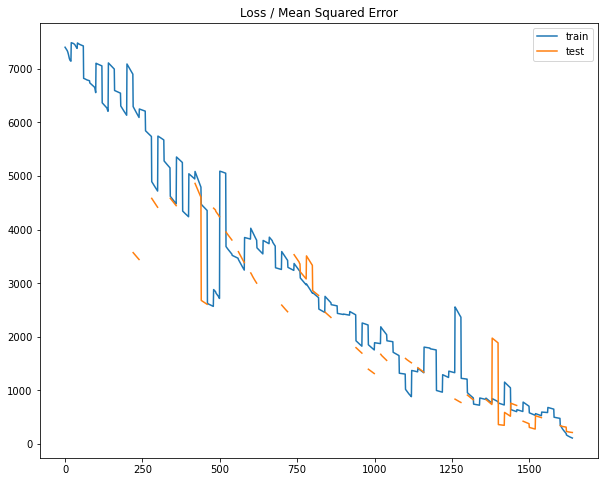

In [13]:
pyplot.figure(figsize=(10,8))
pyplot.title('Loss / Mean Squared Error')
pyplot.plot(hist_df['loss'], label='train')
pyplot.plot(hist_df['val_loss'], label='test')
pyplot.legend()
pyplot.show()

In [16]:
test

<MapDataset shapes: ((None, 20, 6), (None, 1, 2)), types: (tf.float64, tf.float64)>

In [14]:
predict = lstm_model.predict(test, verbose=0)
predict

array([[[-72.720345,  17.87779 ],
        [-89.539696,  22.207363],
        [-92.11757 ,  22.870949],
        ...,
        [-92.528435,  22.976711],
        [-92.52844 ,  22.976711],
        [-92.528435,  22.976711]],

       [[-72.72038 ,  17.8778  ],
        [-89.53972 ,  22.20737 ],
        [-92.11756 ,  22.870947],
        ...,
        [-92.52844 ,  22.976711],
        [-92.528435,  22.976711],
        [-92.528435,  22.976711]],

       [[-72.71978 ,  17.877653],
        [-89.539635,  22.207352],
        [-92.11756 ,  22.870945],
        ...,
        [-92.528435,  22.976711],
        [-92.528435,  22.976711],
        [-92.52844 ,  22.976713]],

       ...,

       [[-72.72013 ,  17.877739],
        [-89.539696,  22.207367],
        [-92.117546,  22.870943],
        ...,
        [-92.52843 ,  22.976707],
        [-92.528435,  22.976711],
        [-92.528435,  22.976711]],

       [[-72.71868 ,  17.877377],
        [-89.5395  ,  22.207314],
        [-92.11753 ,  22.870941],
        .

In [15]:
for element in test.as_numpy_iterator():
  print(element[1])

[[[ -91.252    9.525]]

 [[ -91.148    9.519]]

 [[ -91.217    9.483]]

 [[ -91.262    9.564]]

 [[ -91.095    9.455]]

 [[ -91.301    9.631]]

 [[ -91.291    9.541]]

 [[ -91.237    9.429]]

 [[ -90.974    9.368]]

 [[ -90.797    9.218]]

 [[ -90.478    9.177]]

 [[ -90.48     9.161]]

 [[ -90.47     9.014]]

 [[ -90.045    8.954]]

 [[ -90.308    9.092]]

 [[ -90.027    8.951]]

 [[ -90.206    9.189]]

 [[ -90.212    9.054]]

 [[ -90.121    9.729]]

 [[ -90.226    9.727]]

 [[ -90.57     9.532]]

 [[ -90.385    9.429]]

 [[ -90.381    9.473]]

 [[ -90.777    8.904]]

 [[ -90.478    9.675]]

 [[ -90.471    9.707]]

 [[ -90.639    9.598]]

 [[ -90.284    9.656]]

 [[ -91.981    9.32 ]]

 [[ -90.031    9.678]]

 [[ -90.1      9.783]]

 [[-104.172   13.282]]]
[[[-89.941   9.283]]

 [[-90.049   9.347]]

 [[-90.156   9.265]]

 [[-90.219   9.315]]

 [[-90.166   9.278]]

 [[-90.311   9.2  ]]

 [[-90.276   9.181]]

 [[-90.338   9.035]]

 [[-90.417   9.043]]

 [[-91.29    9.181]]

 [[-90.384  

In [30]:
lstm_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 20, 32)            4992      
_________________________________________________________________
dense (Dense)                (None, 20, 2)             66        
Total params: 5,058
Trainable params: 5,058
Non-trainable params: 0
_________________________________________________________________


In [39]:
window_length = 20

x_test = tf.keras.utils.timeseries_dataset_from_array(
dfs[0][:20], targets=None,sequence_length = window_length, sequence_stride=1, sampling_rate=1,
batch_size=32, shuffle=False, seed=None, start_index=None, end_index=None)

In [40]:
x_test

<BatchDataset shapes: (None, None, 6), types: tf.float64>

In [41]:
lstm_model.predict(x_test)

array([[[-72.72091 ,  17.877968],
        [-89.539764,  22.207386],
        [-92.11759 ,  22.870955],
        [-92.472725,  22.962372],
        [-92.520905,  22.974773],
        [-92.52744 ,  22.97646 ],
        [-92.52832 ,  22.976683],
        [-92.52846 ,  22.976719],
        [-92.52846 ,  22.976719],
        [-92.52846 ,  22.976719],
        [-92.52846 ,  22.976719],
        [-92.52846 ,  22.976719],
        [-92.52846 ,  22.976719],
        [-92.52846 ,  22.976719],
        [-92.52846 ,  22.976719],
        [-92.52846 ,  22.976719],
        [-92.52846 ,  22.976719],
        [-92.52846 ,  22.976719],
        [-92.52846 ,  22.976719],
        [-92.52846 ,  22.976719]]], dtype=float32)